# Week 6: LSTMs and Attention

- Recap
- LSTM
- Attention

## Recap

![RNN](http://karpathy.github.io/assets/rnn/charseq.jpeg)

Source: http://karpathy.github.io/2015/05/21/rnn-effectiveness/

How the hidden state is calculated:

![Hidden state](https://camo.githubusercontent.com/81f93073e5e2ab8d3a3ff63f847fb45be05d0395/68747470733a2f2f63646e2d696d616765732d312e6d656469756d2e636f6d2f6d61782f313434302f302a5455466e4532617243724d72437678482e706e67)


Code source: https://gist.github.com/karpathy/d4dee566867f8291f086

### Important concepts
- **BPTT**

### Vanilla RNN Issues

- Very short memory
- Vanishing/Exploding gradients
- Repetition

In [6]:
0.5*0.5 # 0.5^2

0.25

In [11]:
0.5**15

3.0517578125e-05

## LSTM

In [12]:
import numpy as np
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
plt.style.use('seaborn-white')

In [14]:
data = open('dumas.txt', 'r', encoding='utf8').read()

chars = list(set(data)) 
data_size, vocab_size = len(data), len(chars)
print('data has %d chars, %d unique' % (data_size, vocab_size))

data has 2643851 chars, 107 unique


In [34]:
char_to_idx = {ch:i for i,ch in enumerate(chars)}
idx_to_char = {i:ch for i, ch in enumerate(chars)}
print(char_to_idx)

{'“': 0, 'u': 1, 'ü': 2, 'y': 3, 'J': 4, '!': 5, ')': 6, '—': 7, 'ï': 8, 't': 9, ':': 10, 'æ': 11, '*': 12, 'a': 13, 'm': 14, 'z': 15, 'É': 16, 'c': 17, '6': 18, 'D': 19, '2': 20, '‘': 21, 'Z': 22, '$': 23, '%': 24, 'A': 25, 'h': 26, 'C': 27, 'I': 28, ']': 29, 'Y': 30, '\ufeff': 31, '\n': 32, 'g': 33, '5': 34, 'X': 35, '&': 36, 'é': 37, 'è': 38, '3': 39, 'S': 40, 'L': 41, "'": 42, 'ë': 43, '/': 44, ';': 45, '-': 46, '8': 47, '†': 48, '1': 49, 'x': 50, '[': 51, '’': 52, 's': 53, 'U': 54, '@': 55, 'R': 56, 'E': 57, 'b': 58, 'G': 59, 'k': 60, 'l': 61, '”': 62, 'ê': 63, 'o': 64, 'K': 65, 'í': 66, '(': 67, 'W': 68, 'œ': 69, 'w': 70, '9': 71, ',': 72, 'P': 73, '0': 74, 'O': 75, 'Œ': 76, 'n': 77, 'ô': 78, '#': 79, 'ç': 80, 'f': 81, 'q': 82, 'H': 83, 'd': 84, 'p': 85, '.': 86, '?': 87, 'M': 88, '7': 89, 'V': 90, 'T': 91, 'N': 92, ' ': 93, 'B': 94, 'F': 95, 'j': 96, '4': 97, 'Q': 98, 'v': 99, 'i': 100, 'â': 101, 'à': 102, 'î': 103, 'r': 104, 'Æ': 105, 'e': 106}


In [35]:
H_size = 100 # Size of the hidden layer
T_steps = 25 # Number of time steps (length of the sequence) used for training
learning_rate = 1e-1 # Learning rate
weight_sd = 0.1 # Standard deviation of weights for initialization
z_size = H_size + vocab_size # Size of concatenate(H, X) vector

In [36]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def dsigmoid(y):
    return y * (1 - y)


def tanh(x):
    return np.tanh(x)


def dtanh(y):
    return 1 - y * y

In [37]:
class Param:
    def __init__(self, name, value):
        self.name = name
        self.v = value #parameter value
        self.d = np.zeros_like(value) #derivative
        self.m = np.zeros_like(value) #momentum for AdaGrad

In [38]:
class Parameters:
    def __init__(self):
        self.W_f = Param('W_f', 
                         np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_f = Param('b_f',
                         np.zeros((H_size, 1)))

        self.W_i = Param('W_i',
                         np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_i = Param('b_i',
                         np.zeros((H_size, 1)))

        self.W_C = Param('W_C',
                         np.random.randn(H_size, z_size) * weight_sd)
        self.b_C = Param('b_C',
                         np.zeros((H_size, 1)))

        self.W_o = Param('W_o',
                         np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_o = Param('b_o',
                         np.zeros((H_size, 1)))

        #For final layer to predict the next character
        self.W_v = Param('W_v',
                         np.random.randn(vocab_size, H_size) * weight_sd)
        self.b_v = Param('b_v',
                         np.zeros((vocab_size, 1)))
        
    def all(self):
        return [self.W_f, self.W_i, self.W_C, self.W_o, self.W_v,
               self.b_f, self.b_i, self.b_C, self.b_o, self.b_v]
        
parameters = Parameters()

In [39]:
def forward(x, h_prev, C_prev, p = parameters):
    assert x.shape == (vocab_size, 1)
    assert h_prev.shape == (H_size, 1)
    assert C_prev.shape == (H_size, 1)
    
    z = np.row_stack((h_prev, x))
    f = sigmoid(np.dot(p.W_f.v, z) + p.b_f.v)
    i = sigmoid(np.dot(p.W_i.v, z) + p.b_i.v)
    C_bar = tanh(np.dot(p.W_C.v, z) + p.b_C.v)

    C = f * C_prev + i * C_bar
    o = sigmoid(np.dot(p.W_o.v, z) + p.b_o.v)
    h = o * tanh(C)

    v = np.dot(p.W_v.v, h) + p.b_v.v
    y = np.exp(v) / np.sum(np.exp(v)) #softmax

    return z, f, i, C_bar, C, o, h, v, y

In [40]:
def backward(target, dh_next, dC_next, C_prev,
             z, f, i, C_bar, C, o, h, v, y,
             p = parameters):
    
    assert z.shape == (vocab_size + H_size, 1)
    assert v.shape == (vocab_size, 1)
    assert y.shape == (vocab_size, 1)
    
    for param in [dh_next, dC_next, C_prev, f, i, C_bar, C, o, h]:
        assert param.shape == (H_size, 1)
        
    dv = np.copy(y)
    dv[target] -= 1

    p.W_v.d += np.dot(dv, h.T)
    p.b_v.d += dv

    dh = np.dot(p.W_v.v.T, dv)        
    dh += dh_next
    do = dh * tanh(C)
    do = dsigmoid(o) * do
    p.W_o.d += np.dot(do, z.T)
    p.b_o.d += do

    dC = np.copy(dC_next)
    dC += dh * o * dtanh(tanh(C))
    dC_bar = dC * i
    dC_bar = dtanh(C_bar) * dC_bar
    p.W_C.d += np.dot(dC_bar, z.T)
    p.b_C.d += dC_bar

    di = dC * C_bar
    di = dsigmoid(i) * di
    p.W_i.d += np.dot(di, z.T)
    p.b_i.d += di

    df = dC * C_prev
    df = dsigmoid(f) * df
    p.W_f.d += np.dot(df, z.T)
    p.b_f.d += df

    dz = (np.dot(p.W_f.v.T, df)
         + np.dot(p.W_i.v.T, di)
         + np.dot(p.W_C.v.T, dC_bar)
         + np.dot(p.W_o.v.T, do))
    dh_prev = dz[:H_size, :]
    dC_prev = f * dC
    
    return dh_prev, dC_prev

In [41]:
def clear_gradients(params = parameters):
    for p in params.all():
        p.d.fill(0)

In [42]:
def clip_gradients(params = parameters):
    for p in params.all():
        np.clip(p.d, -1, 1, out=p.d)

In [43]:
def forward_backward(inputs, targets, h_prev, C_prev):
    global paramters
    
    # To store the values for each time step
    x_s, z_s, f_s, i_s,  = {}, {}, {}, {}
    C_bar_s, C_s, o_s, h_s = {}, {}, {}, {}
    v_s, y_s =  {}, {}
    
    # Values at t - 1
    h_s[-1] = np.copy(h_prev)
    C_s[-1] = np.copy(C_prev)
    
    loss = 0
    # Loop through time steps
    assert len(inputs) == T_steps
    for t in range(len(inputs)):
        x_s[t] = np.zeros((vocab_size, 1))
        x_s[t][inputs[t]] = 1 # Input character
        
        (z_s[t], f_s[t], i_s[t],
        C_bar_s[t], C_s[t], o_s[t], h_s[t],
        v_s[t], y_s[t]) = \
            forward(x_s[t], h_s[t - 1], C_s[t - 1]) # Forward pass
            
        loss += -np.log(y_s[t][targets[t], 0]) # Loss for at t
        
    clear_gradients()

    dh_next = np.zeros_like(h_s[0]) #dh from the next character
    dC_next = np.zeros_like(C_s[0]) #dh from the next character

    for t in reversed(range(len(inputs))):
        # Backward pass
        dh_next, dC_next = \
            backward(target = targets[t], dh_next = dh_next,
                     dC_next = dC_next, C_prev = C_s[t-1],
                     z = z_s[t], f = f_s[t], i = i_s[t], C_bar = C_bar_s[t],
                     C = C_s[t], o = o_s[t], h = h_s[t], v = v_s[t],
                     y = y_s[t])

    clip_gradients()
        
    return loss, h_s[len(inputs) - 1], C_s[len(inputs) - 1]

In [44]:
def sample(h_prev, C_prev, first_char_idx, sentence_length):
    x = np.zeros((vocab_size, 1))
    x[first_char_idx] = 1

    h = h_prev
    C = C_prev

    indexes = []
    
    for t in range(sentence_length):
        _, _, _, _, C, _, h, _, p = forward(x, h, C)
        idx = np.random.choice(range(vocab_size), p=p.ravel())
        x = np.zeros((vocab_size, 1))
        x[idx] = 1
        indexes.append(idx)

    return indexes

In [45]:
def update_status(inputs, h_prev, C_prev):
    #initialized later
    global plot_iter, plot_loss
    global smooth_loss
    
    # Get predictions for 200 letters with current model

    sample_idx = sample(h_prev, C_prev, inputs[0], 200)
    txt = ''.join(idx_to_char[idx] for idx in sample_idx)

    # Clear and plot
    plt.plot(plot_iter, plot_loss)
    #display.clear_output(wait=True)
    plt.show()

    #Print prediction and loss
    print("----\n %s \n----" % (txt, ))
    print("iter %d, loss %f" % (iteration, smooth_loss))

In [46]:
def update_paramters(params = parameters):
    for p in params.all():
        p.m += p.d * p.d # Calculate sum of gradients
        #print(learning_rate * dparam)
        p.v += -(learning_rate * p.d / np.sqrt(p.m + 1e-8))

In [47]:
import signal

class DelayedKeyboardInterrupt(object):
    def __enter__(self):
        self.signal_received = False
        self.old_handler = signal.signal(signal.SIGINT, self.handler)

    def handler(self, sig, frame):
        self.signal_received = (sig, frame)
        print('SIGINT received. Delaying KeyboardInterrupt.')

    def __exit__(self, type, value, traceback):
        signal.signal(signal.SIGINT, self.old_handler)
        if self.signal_received:
            self.old_handler(*self.signal_received)

In [48]:
# Exponential average of loss
# Initialize to a error of a random model
smooth_loss = -np.log(1.0 / vocab_size) * T_steps

iteration, pointer = 0, 0

# For the graph
plot_iter = np.zeros((0))
plot_loss = np.zeros((0))

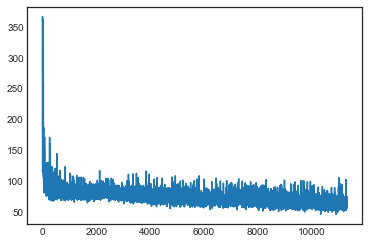

----
 Hago(he ghCinred risrelid  re reurgif bt bon whe dhe yily bo thtovtvgarle,re
nats 7thethoser sof hor, sarannedas h
ast  iruro us tehe be, reu. irt Hannrosis int 
tirt akgjen y pl rolrDniin rofinr mace 
----
iter 11322, loss 65.742709


In [49]:
while True:
    try:
        with DelayedKeyboardInterrupt():
            # Reset
            if pointer + T_steps >= len(data) or iteration == 0:
                g_h_prev = np.zeros((H_size, 1))
                g_C_prev = np.zeros((H_size, 1))
                pointer = 0


            inputs = ([char_to_idx[ch] 
                       for ch in data[pointer: pointer + T_steps]])
            targets = ([char_to_idx[ch] 
                        for ch in data[pointer + 1: pointer + T_steps + 1]])

            loss, g_h_prev, g_C_prev = \
                forward_backward(inputs, targets, g_h_prev, g_C_prev)
            smooth_loss = smooth_loss * 0.999 + loss * 0.001

            # Print every hundred steps
            if iteration % 100 == 0:
                update_status(inputs, g_h_prev, g_C_prev)

            update_paramters()

            plot_iter = np.append(plot_iter, [iteration])
            plot_loss = np.append(plot_loss, [loss])

            pointer += T_steps
            iteration += 1
    except KeyboardInterrupt:
        update_status(inputs, g_h_prev, g_C_prev)
        break

## Attention